In [1]:
 !pip install gradio==3.50

In [2]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
import pathlib

In [3]:
data_dir = pathlib.Path("C:/Users/S G Sumanth/Downloads/ACNE_DATASET/ACNE DATASET")

In [4]:
# Parameters
img_height, img_width = 180, 180
batch_size = 32

In [5]:
# Prepare the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 227 files belonging to 2 classes.
Using 182 files for training.


In [6]:
# Prepare the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 227 files belonging to 2 classes.
Using 45 files for validation.


In [7]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
])

In [8]:
# Classes in the dataset
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Acne', 'non acne']


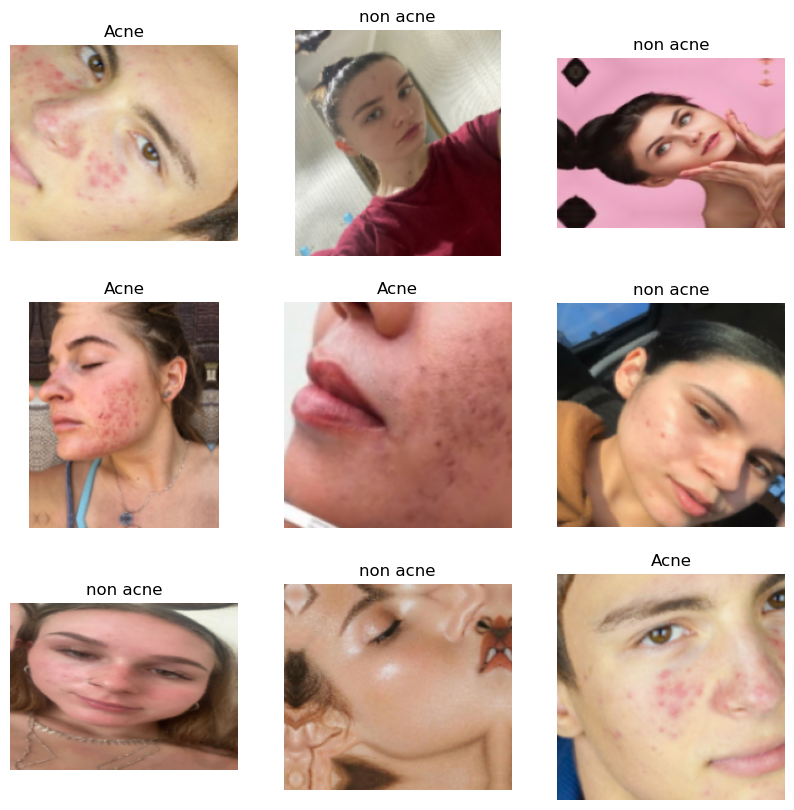

In [9]:
# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(images[i].numpy().astype("uint8"))
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
# Prefetch data for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Define the model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

C:\Users\S G Sumanth\AppData\Local\Temp\ipykernel_17512\2615524776.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


In [12]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

In [13]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional" is incompatible with the layer: expected shape=(None, 180, 3), found shape=(None, 180, 180, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 180, 180, 3), dtype=float32, sparse=None, name=keras_tensor_160>',)
  • kwargs={'mask': 'None'}

In [16]:
# Fine-tune the model
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
fine_tune_epochs = 10
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs
)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional" is incompatible with the layer: expected shape=(None, 180, 3), found shape=(None, 180, 180, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(None, 180, 180, 3), dtype=float32, sparse=None, name=keras_tensor_160>',)
  • kwargs={'mask': 'None'}

In [17]:
# Prediction function
def predict_image(img):
    img_4d = img.reshape(-1, img_height, img_width, 3)
    prediction = model.predict(img_4d)[0]
    return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}

In [ ]:
# Gradio interface
image = gr.inputs.Image(shape=(img_height, img_width))
label = gr.outputs.Label(num_top_classes=len(class_names))

gr.Interface(fn=predict_image, inputs=image, outputs=label, interpretation='default').launch(debug=True)


C:\Users\S G Sumanth\AppData\Local\Temp\ipykernel_17512\2383216522.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(img_height, img_width))
C:\Users\S G Sumanth\AppData\Local\Temp\ipykernel_17512\2383216522.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(img_height, img_width))
C:\Users\S G Sumanth\AppData\Local\Temp\ipykernel_17512\2383216522.py:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label(num_top_classes=len(class_names))
C:\Users\S G Sumanth\AppData\Local\Temp\ipykernel_17512\2383216522.py:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label(n

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 3.50.0, however version 4.44.1 is available, please upgrade.
--------


Traceback (most recent call last):
  File "C:\Users\S G Sumanth\anaconda3\Lib\site-packages\gradio\routes.py", line 534, in predict
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\S G Sumanth\anaconda3\Lib\site-packages\gradio\route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\S G Sumanth\anaconda3\Lib\site-packages\gradio\blocks.py", line 1550, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\S G Sumanth\anaconda3\Lib\site-packages\gradio\blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\S G Sumanth\anaconda3\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^